In [2]:
import numpy as np
import pandas as pd
import json
import os

## Load latest execution full

In [3]:
full = pd.read_csv("Full/full_3.csv", index_col=0)
full = full.drop(['dram_read_bytes (dev_approximate_gravity)'], axis=1, errors='ignore')

/tmp/ipykernel_372354/1990568059.py:1: DtypeWarning: Columns (58,76,78,100,153) have mixed types. Specify dtype option on import or set low_memory=False.
  full = pd.read_csv("Full/full_3.csv", index_col=0)


## Load latest full error

In [3]:
full_err_df = pd.read_csv("Full/full_err.csv", index_col=0)

## Preprocessing

### GPU Correlation

In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

# "N","theta","dt",
X = full[["Clock Rate (MHz)","Compute Capability",
                "Total Memory (MB)",
                "Multiprocessors (SMs)",
                "Max Threads Per SM",
                "Total Cores",
                "Warp Size",
                "Max Threads Per Block",
                "Max Blocks Per SM",
                "Shared Memory Per Block (KB)",
                "Shared Memory Per SM (KB)",
                "Registers Per Block",
                "Registers Per SM",
                "L1 Cache Size (KB)",
                "L2 Cache Size (KB)",
                "Memory Bus Width (bits)",
                "Memory Bandwidth (GB/s)",
                "Clock Rate (MHz)",
                "Warps Per SM",
                "Blocks Per SM",
                "Half Precision FLOP/s",
                "Single Precision FLOP/s",
                "Double Precision FLOP/s",
                "Concurrent Kernels",
                "Threads Per Warp",
                "Global Memory Bandwidth (GB/s)",
                "Global Memory Size (MB)",
                "L2 Cache Size",
                "Memcpy Engines"]].apply(pd.to_numeric, errors='coerce')

y = full["exec_time_avg"].apply(pd.to_numeric, errors='coerce')

# define feature selection
fs = SelectKBest(score_func=mutual_info_regression, k=5)

# apply feature selection
X_selected = fs.fit_transform(X, y)
print(X_selected.shape)
print(fs.get_feature_names_out())


(2100, 5)
['Multiprocessors (SMs)' 'Total Cores' 'Half Precision FLOP/s'
 'Single Precision FLOP/s' 'Double Precision FLOP/s']


### Profiling Correlation analysis

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler


sim_params = ["N","theta","dt","I"]
exec_times = ["exec_time_min","exec_time_max"] # "exec_time_avg"
gpu_params = ["profiling",
                "Name",
                "Compute Capability",
                "Total Memory (MB)",
                "Multiprocessors (SMs)",
                "Max Threads Per SM",
                "Total Cores",
                "Warp Size",
                "Max Threads Per Block",
                "Max Blocks Per SM",
                "Shared Memory Per Block (KB)",
                "Shared Memory Per SM (KB)",
                "Registers Per Block",
                "Registers Per SM",
                "L1 Cache Size (KB)",
                "L2 Cache Size (KB)",
                "Memory Bus Width (bits)",
                "Memory Bandwidth (GB/s)",
                "Clock Rate (MHz)",
                "Warps Per SM",
                "Blocks Per SM",
                "Half Precision FLOP/s",
                "Single Precision FLOP/s",
                "Double Precision FLOP/s",
                "Concurrent Kernels",
                "Threads Per Warp",
                "Global Memory Bandwidth (GB/s)",
                "Global Memory Size (MB)",
                "L2 Cache Size",
                "Memcpy Engines"
                ]

df = full.drop(sim_params + exec_times + gpu_params,axis=1).apply(pd.to_numeric, errors='coerce')


print(df.shape)

# print(df.dtypes.to_string())
# Step 1: Log Scaling (handle zero values by adding a small constant if needed)
df_scaled = np.log1p(df)  # Use log1p to avoid issues with zero values (log(x+1))

# Step 2: Normalization (scaling between 0 and 1)
scaler = MinMaxScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(df_scaled), columns=df.columns)

# Step 1: Compute the correlation matrix
correlation_matrix = df_normalized.corr(method='spearman').abs()  # Using absolute values for correlation strength

# Step 2: Set the threshold and identify columns with high correlations (excluding self-correlations)
threshold = 0.95

kernel_corr = correlation_matrix['exec_time_avg']

# Use a mask to exclude diagonal (self-correlations) by setting them to False
# high_corr_mask = (kernel_corr > threshold) & (kernel_corr != 1.0)

# # Identify columns with any high correlation
# high_corr_columns = high_corr_mask.any(axis=1).index[high_corr_mask.any(axis=1).values]

high_corr_features = kernel_corr[(kernel_corr) > threshold].index.tolist()
high_corr_features = [feature for feature in high_corr_features if feature != 'exec_time_avg']

# Step 3: Filter the DataFrame to include only columns with high correlation pairs
filtered_df = df[high_corr_features]

# Display the resulting filtered DataFrame
# print(kernel_corr.to_string())
display(filtered_df)
print(filtered_df.shape)

# Step 5: Display results
print("Features correlated with Kernel Execution Times above the threshold:")
for feature in high_corr_features:
    print(f"{feature}: Correlation = {kernel_corr[feature]:.2f}")

(2100, 635)


,l2_subp0_read_tex_sector_queries (dev_approximate_gravity),l2_subp1_read_tex_sector_queries (dev_approximate_gravity),l2_subp0_write_tex_sector_queries (dev_approximate_gravity),l2_subp1_write_tex_sector_queries (dev_approximate_gravity),l2_subp0_read_tex_hit_sectors (dev_approximate_gravity),l2_subp1_read_tex_hit_sectors (dev_approximate_gravity),l2_subp0_total_read_sector_queries (dev_approximate_gravity),l2_subp1_total_read_sector_queries (dev_approximate_gravity),inst_issued1 (dev_approximate_gravity),inst_executed (dev_approximate_gravity),...,inst_control (predict_particles),inst_compute_ld_st (predict_particles),issue_slots (predict_particles),l2_tex_read_transactions (predict_particles),l2_tex_write_transactions (predict_particles),inst_executed_global_loads (predict_particles),inst_executed_global_stores (predict_particles),global_load_requests (predict_particles),global_store_requests (predict_particles),sm_efficiency (predict_particles)
0,7941.0,6917.0,4534.0,3809.0,7397.0,6490.0,9756.0,7398.0,2.132750e+05,3.029380e+05,...,128.0,600.0,200.0,175.0,100.0,16.0,8.0,52.0,100.0,2.504904
1,7685.0,6969.0,4380.0,3963.0,7552.0,6515.0,9472.0,7445.0,2.132750e+05,3.029380e+05,...,128.0,600.0,200.0,175.0,100.0,16.0,8.0,52.0,100.0,2.633358
2,7933.0,6884.0,4349.0,3994.0,7508.0,6406.0,9773.0,7516.0,2.132690e+05,3.029380e+05,...,128.0,600.0,200.0,175.0,100.0,16.0,8.0,52.0,100.0,2.744356
3,7355.0,7002.0,4194.0,3975.0,7036.0,6534.0,9146.0,7522.0,2.091540e+05,2.976570e+05,...,128.0,600.0,200.0,175.0,100.0,16.0,8.0,52.0,100.0,2.867770
4,7865.0,7247.0,4281.0,3974.0,7463.0,6862.0,17668.0,15825.0,2.181090e+05,3.089810e+05,...,128.0,600.0,200.0,175.0,100.0,16.0,8.0,52.0,100.0,3.106254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2095,896577159.0,896577159.0,598422773.0,598422773.0,877161706.0,877161706.0,898426601.0,898426601.0,2.404945e+10,2.404502e+10,...,10035072.0,60000000.0,12518340.0,17500000.0,10000000.0,1250000.0,625000.0,1250000.0,625000.0,99.860000
2096,597699011.0,597699011.0,406592926.0,406592926.0,582291728.0,582291728.0,599269788.0,599269788.0,1.745602e+10,1.745317e+10,...,10035072.0,60000000.0,12518344.0,17500000.0,10000000.0,1250000.0,625000.0,1250000.0,625000.0,99.870000
2097,583883785.0,583883785.0,397315255.0,397315255.0,568016905.0,568016905.0,585151768.0,585151768.0,1.678283e+10,1.678014e+10,...,10035072.0,60000000.0,12518384.0,17500000.0,10000000.0,1250000.0,625000.0,1250000.0,625000.0,99.900000
2098,583097438.0,583097438.0,396613327.0,396613327.0,567324478.0,567324478.0,584360521.0,584360521.0,1.676663e+10,1.676405e+10,...,10035072.0,60000000.0,12518360.0,17500000.0,10000000.0,1250000.0,625000.0,1250000.0,625000.0,99.860000


(2100, 124)
Features correlated with Kernel Execution Times above the threshold:
l2_subp0_read_tex_sector_queries (dev_approximate_gravity): Correlation = 0.97
l2_subp1_read_tex_sector_queries (dev_approximate_gravity): Correlation = 0.97
l2_subp0_write_tex_sector_queries (dev_approximate_gravity): Correlation = 0.95
l2_subp1_write_tex_sector_queries (dev_approximate_gravity): Correlation = 0.95
l2_subp0_read_tex_hit_sectors (dev_approximate_gravity): Correlation = 0.97
l2_subp1_read_tex_hit_sectors (dev_approximate_gravity): Correlation = 0.97
l2_subp0_total_read_sector_queries (dev_approximate_gravity): Correlation = 0.96
l2_subp1_total_read_sector_queries (dev_approximate_gravity): Correlation = 0.96
inst_issued1 (dev_approximate_gravity): Correlation = 0.96
inst_executed (dev_approximate_gravity): Correlation = 0.96
thread_inst_executed (dev_approximate_gravity): Correlation = 0.96
not_predicated_off_thread_inst_executed (dev_approximate_gravity): Correlation = 0.96
active_cycles (

In [6]:
print(kernel_corr[high_corr_features].to_latex())

\begin{tabular}{lr}
\toprule
 & exec_time_avg \\
\midrule
l2_subp0_read_tex_sector_queries (dev_approximate_gravity) & 0.968513 \\
l2_subp1_read_tex_sector_queries (dev_approximate_gravity) & 0.968412 \\
l2_subp0_write_tex_sector_queries (dev_approximate_gravity) & 0.951488 \\
l2_subp1_write_tex_sector_queries (dev_approximate_gravity) & 0.951387 \\
l2_subp0_read_tex_hit_sectors (dev_approximate_gravity) & 0.969197 \\
l2_subp1_read_tex_hit_sectors (dev_approximate_gravity) & 0.969126 \\
l2_subp0_total_read_sector_queries (dev_approximate_gravity) & 0.957361 \\
l2_subp1_total_read_sector_queries (dev_approximate_gravity) & 0.957269 \\
inst_issued1 (dev_approximate_gravity) & 0.956023 \\
inst_executed (dev_approximate_gravity) & 0.957873 \\
thread_inst_executed (dev_approximate_gravity) & 0.958336 \\
not_predicated_off_thread_inst_executed (dev_approximate_gravity) & 0.958368 \\
active_cycles (dev_approximate_gravity) & 0.953069 \\
global_load (dev_approximate_gravity) & 0.962263 \\
glob

### Profiling Clustering analysis

(124, 124)
Selected features with highest variance from each cluster:
['gld_transactions (dev_approximate_gravity)',
 'thread_inst_executed (dev_approximate_gravity)',
 'inst_compute_ld_st (correct_particles)',
 'active_warps_pm (correct_particles)',
 'global_store_requests (correct_particles)']


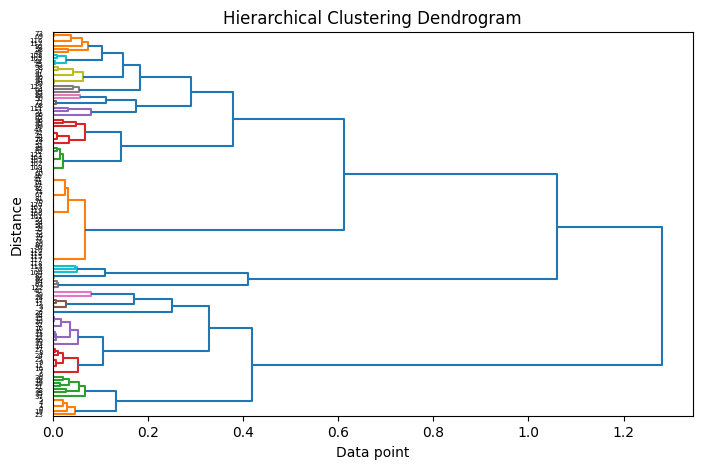

Number of Parameters: 5
Features by Cluster:
{1: ['l2_subp0_read_tex_sector_queries (dev_approximate_gravity)',
     'l2_subp1_read_tex_sector_queries (dev_approximate_gravity)',
     'l2_subp0_read_tex_hit_sectors (dev_approximate_gravity)',
     'l2_subp1_read_tex_hit_sectors (dev_approximate_gravity)',
     'inst_per_warp (dev_approximate_gravity)',
     'local_load_transactions (dev_approximate_gravity)',
     'gld_transactions (dev_approximate_gravity)',
     'l2_read_transactions (dev_approximate_gravity)',
     'l2_tex_read_transactions (dev_approximate_gravity)',
     'global_load_requests (dev_approximate_gravity)',
     'local_load_requests (dev_approximate_gravity)',
     'global_store_requests (dev_approximate_gravity)',
     'local_store_requests (dev_approximate_gravity)'],
 2: ['l2_subp0_write_tex_sector_queries (dev_approximate_gravity)',
     'l2_subp1_write_tex_sector_queries (dev_approximate_gravity)',
     'l2_subp0_total_read_sector_queries (dev_approximate_gravity

In [7]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.stats import zscore
import matplotlib.pyplot as plt 
import pprint

# Sample DataFrame, replace this with your actual DataFrame
# df = pd.DataFrame({
#     'Metric1': [100, 200, 300, 400, 500],
#     'Metric2': [10, 20, 30, 40, 50],
#     'Metric3': [5, 10, 15, 20, 25],
#     'Metric4': [1, 1, 1, 1, 1]
# })

df_scaled = np.log1p(df[high_corr_features])  # Use log1p to avoid issues with zero values (log(x+1))

# Step 2: Normalization (scaling between 0 and 1)
scaler = MinMaxScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(df_scaled), columns=df_scaled.columns)

# Step 1: Compute the correlation matrix
SCC = df_normalized.corr(method='spearman').fillna(0).abs()  # Using absolute values for correlation strength

# # Step 1: Calculate the correlation matrix (SCC)
# SCC = df.corr(method='spearman')
print(SCC.shape)
# Step 2: Perform hierarchical clustering
dendroG = linkage(SCC, method='ward')

# Function to cut the dendrogram and return features with highest variance
def cut_dendrogram_and_variance(dendroG, num_params, _df):
    # Cut the dendrogram to get clusters
    cutDendro = fcluster(dendroG, num_params, criterion='maxclust')
    
    # Create a DataFrame with cluster labels
    clusters = pd.Series(cutDendro, index=SCC.columns)
    
    # Group features by their clusters
    grouped_features = {}
    for cluster in clusters.unique():
        grouped_features[cluster] = clusters[clusters == cluster].index.tolist()
    
    # Calculate variance for each group of features
    variance_dict = {}
    for cluster, features in grouped_features.items():
        # Select features and calculate their variance
        feature_data = _df[features]
        variance_value = feature_data.var().sum()  # Total variance of the group
        variance_dict[cluster] = variance_value
    
    # Plot dendrogram 
    dendrogram(dendroG, orientation="right",  color_threshold =0.1) 
    
    plt.title('Hierarchical Clustering Dendrogram') 
    plt.subplots_adjust(left=8, right=9, top=0.9, bottom=0.1)
    plt.xlabel('Data point') 
    plt.ylabel('Distance') 
    plt.show()

    
    return grouped_features, variance_dict

def select_high_variance_feature(dendroG, _df, num_params):
    # Cut the dendrogram to form clusters
    cutDendro = fcluster(dendroG, num_params, criterion='maxclust')
    
    # Map each column to its cluster label
    clusters = pd.Series(cutDendro, index=SCC.columns)
    
    # For each cluster, find the feature with the maximum variance
    selected_features = []
    for cluster in clusters.unique():
        # Get the features in this cluster
        cluster_features = clusters[clusters == cluster].index.tolist()
        
        # Calculate variance for each feature in the cluster
        variances = _df[cluster_features].var()
        
        # Select the feature with the highest variance
        selected_feature = variances.idxmax()
        selected_features.append(selected_feature)
    
    return selected_features

# Step 4: Define number of clusters and select features
# Step 3: Loop through the number of parameters and compute variance
for No_Param in [5]:  # For No. Param in [5, 10]
    selected_features = select_high_variance_feature(dendroG, df, No_Param)
    # Step 5: Display the selected features
    print("Selected features with highest variance from each cluster:")
    pprint.pprint(selected_features)
    features, variance = cut_dendrogram_and_variance(dendroG, No_Param,df_normalized)
    print(f"Number of Parameters: {No_Param}")
    print("Features by Cluster:")
    pprint.pprint(features)
    print("Variance by Cluster:", variance)
    print()  # New line for better readability


### Final profiling features

In [8]:
selected_features

['gld_transactions (dev_approximate_gravity)',
 'thread_inst_executed (dev_approximate_gravity)',
 'inst_compute_ld_st (correct_particles)',
 'active_warps_pm (correct_particles)',
 'global_store_requests (correct_particles)']